# **Eksplorasi Data Ecommerce: Post-order customer problems**

Muhammad Ibrahim Al Muwahidan / `almuwahidan@gmail.com`

---

In this exploration, we as data analysts in Post-order Team, would like to uncover possible customer pain points regarding their post-order journey.

This analysis hopefully will help answer some questions such as:
- Whether our customers have negative experiences in terms of item delivery
- The drivers of delivery problems if there's any: whether the delivery operations itself, or sellers are simply too far from the customers

In [682]:
# import libraries

from datetime import datetime
from haversine import haversine
from scipy import stats
import gc
import unidecode
import pandas as pd
import seaborn as sns

In [683]:
# supporting functions

def diff_date(date1, date2):
    """Calculate the time elapsed between two dates (in days)"""
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2 - d1).days)

---

### **0. data prep**

#### First dataset: Order reviews + delivery duration

First, we load the dataset we have prepared from previous SQL query `1-delivery-duration-review.csv`

In [684]:
raw_data = pd.read_csv('../db/1-duration-review.csv')

print(f"number of rows: {len(raw_data)}")
raw_data.head()

number of rows: 52678


,review_score,purchase_date,approved_date,delivered_date
0,4,2018-07-24,2018-07-26,2018-08-07
1,5,2018-08-08,2018-08-08,2018-08-17
2,5,2018-02-13,2018-02-13,2018-02-16
3,5,2018-06-07,2018-06-09,2018-06-19
4,5,2018-07-25,2018-07-25,2018-07-30


Then, we drop rows with `NULL` or `NaN` values

In [685]:
raw_data = raw_data.dropna(axis=0, how='any')

print(f"number of rows: {len(raw_data)}")

number of rows: 52672


After that, we use Python to transform the data into a format we can work with easily:
- Calculate delivery duration from purchase date + delivered date data

In [686]:
orders_df1 = pd.DataFrame()

# Use list comprehension to add each columns separately
orders_df1['review_score'] = raw_data['review_score']
orders_df1['delivery_duration'] = [diff_date(purchase, delivery) for purchase, delivery in zip(raw_data['purchase_date'], raw_data['delivered_date'])]

print(f"number of rows: {len(orders_df1)}")
orders_df1.head()

number of rows: 52672


,review_score,delivery_duration
0,4,14
1,5,9
2,5,3
3,5,12
4,5,5


When the new dataset has been created, we can delete the `raw_data` dataframe, to free up memory.

In [687]:
del raw_data
gc.collect()

563

#### Second dataset: Order delivery duration + distance

First, we load the dataset we have prepared from previous SQL query `1-delivery-duration-review.csv`

In [688]:
raw_data = pd.read_csv('../db/2-duration-distance.csv')

raw_data['seller_city'] = raw_data['seller_city'].str.strip()
raw_data['customer_city'] = raw_data['customer_city'].str.strip()

print(f"number of rows: {len(raw_data)}")
raw_data.head()

number of rows: 52530


,purchase_date,delivered_date,seller_lat,seller_lng,seller_city,customer_lat,customer_lng,customer_city
0,2018-01-14,2018-01-22,-22.262584,-46.171124,borda da mata,-19.870305,-44.593326,pará de minas
1,2018-08-08,2018-08-14,-20.553624,-47.387359,franca,-23.089925,-46.611654,atibaia
2,2018-07-04,2018-07-09,-22.122735,-51.386369,presidente prudente,-24.014395,-46.438358,praia grande
3,2018-03-19,2018-03-29,-23.515978,-46.547372,sao paulo,-23.954600,-46.337731,santos
4,2018-07-02,2018-07-04,-23.467052,-46.587921,sao paulo,-23.556620,-46.899041,jandira


Then, we drop rows with `NULL` or `NaN` values

In [689]:
raw_data = raw_data.dropna(axis=0, how='any')

print(f"number of rows: {len(raw_data)}")

number of rows: 52524


After that, we use Python to transform the data into a format we can work with easily:
- Calculate delivery duration from purchase date + delivered date data
- Calculate distance from seller to customer using haversine formula

In [690]:
orders_df2 = pd.DataFrame()

# Fill the month data
orders_df2['purchase_date'] = pd.to_datetime(raw_data['purchase_date'], format='%Y-%m-%d')
orders_df2['purchase_month'] = pd.DatetimeIndex(orders_df2['purchase_date']).month
orders_df2 = orders_df2.drop(columns=['purchase_date'])

# Copy the seller and customer cities
orders_df2['seller_city'] = raw_data['seller_city']
orders_df2['customer_city'] = raw_data['customer_city']

# Calculate delivery duration data
orders_df2['delivery_duration'] = [diff_date(purchase, delivery) for purchase, delivery in zip(raw_data['purchase_date'], raw_data['delivered_date'])]

# Calculate distance data
seller_coords = zip(raw_data['seller_lat'], raw_data['seller_lng'])
buyer_coords = zip(raw_data['customer_lat'], raw_data['customer_lng'])
orders_df2['delivery_distance'] = [round(haversine(seller_coord, buyer_coord, unit='km'), 3) for seller_coord, buyer_coord in zip(seller_coords, buyer_coords)]

# Print the table
print(f"number of rows: {len(orders_df2)}")
orders_df2.head()

number of rows: 52524


,purchase_month,seller_city,customer_city,delivery_duration,delivery_distance
0,1,borda da mata,pará de minas,8,312.344
1,8,franca,atibaia,6,293.169
2,7,presidente prudente,praia grande,5,548.107
3,3,sao paulo,santos,10,53.237
4,7,sao paulo,jandira,2,33.250


Then, we need to make sure the city names are uniform. We do this by:
- looking at the unique values first (already done during SQL stage)
- replace whitespaces (already done during SQL stage)
- Fix typos (not included in this step)
- Standardize accented characters

In [691]:
orders_df2.query('seller_city.str.contains("o paulo")')['seller_city'].unique()

array(['sao paulo', 'são paulo'], dtype=object)

From the result above, we can see that `"sao paulo"` and `"são paulo"` are both considered unique, due to the accented character `ã`.

We'll standardize this using `unidecode()` function.

In [692]:
# Apply the function unidecode() to each of the cities
orders_df2['seller_city'] = orders_df2['seller_city'].apply(unidecode.unidecode)
orders_df2['customer_city'] = orders_df2['customer_city'].apply(unidecode.unidecode)


# Print the unique value again
orders_df2.query('seller_city.str.contains("o paulo")')['seller_city'].unique()

array(['sao paulo'], dtype=object)

Then, we can simplify the column to whether the order delivery is intercity or not.

In [693]:
orders_df2['is_intercity'] = ["FALSE" if city1 == city2 else "TRUE" for city1, city2 in zip(orders_df2['seller_city'], orders_df2['customer_city'])]

orders_df2 = orders_df2.drop(columns=['seller_city', 'customer_city'])

orders_df2.head()

,purchase_month,delivery_duration,delivery_distance,is_intercity
0,1,8,312.344,TRUE
1,8,6,293.169,TRUE
2,7,5,548.107,TRUE
3,3,10,53.237,TRUE
4,7,2,33.250,TRUE


We're done!

Now that the new dataset has been created, we can delete the `raw_data` dataframe, to free up memory.

In [694]:
del raw_data
del seller_coords
del buyer_coords
gc.collect()

43

---

### **1. Quantitatively validating whether delivery is a customer pain-point**

Step 1:

Look at distribution and remove outliers, if any.

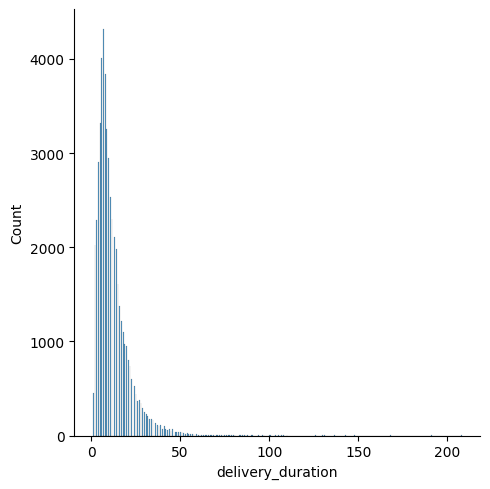

In [695]:
sns.displot(data=orders_df1, x="delivery_duration")

From the distribution above, we can see that there are a long tail towards a higher delivery duration.

We will strategize around this by:
- Creating another dataset with outliers removed. Note: 'outlier' in this case means |z_score| > 3.
- Do correlation analysis for both datasets, see how the score change

In [696]:
# Calculate Z-score for delivery duration

delivery_duration_z_scores = stats.zscore(orders_df1['delivery_duration'])

orders_df1_nooutliers = pd.DataFrame()

# If Z score < 3, then it's not outlier
orders_df1_nooutliers['delivery_duration'] = [duration for duration, z_score in zip(orders_df1['delivery_duration'], delivery_duration_z_scores) if z_score < 3]
orders_df1_nooutliers['review_score'] = [score for score, z_score in zip(orders_df1['review_score'], delivery_duration_z_scores) if z_score < 3]

pct_data_removed = (len(orders_df1) - len(orders_df1_nooutliers)) / len(orders_df1)

print(f"{len(orders_df1) - len(orders_df1_nooutliers)} outlier rows removed, which consist of {pct_data_removed*100:.2f}% of the whole dataset.")


# clean up big array
del delivery_duration_z_scores

gc.collect()

921 outlier rows removed, which consist of 1.75% of the whole dataset.


67

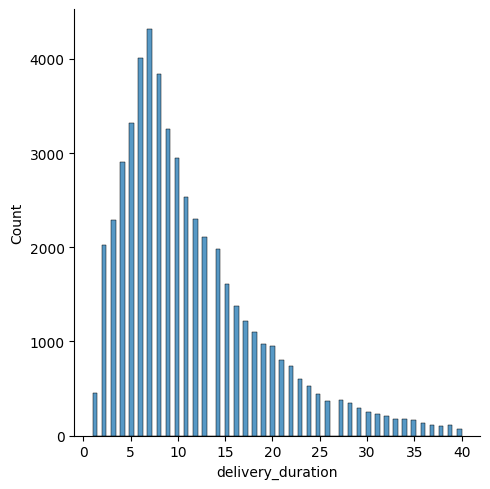

In [697]:
sns.displot(data=orders_df1_nooutliers, x='delivery_duration')

Step 2:

Now that we have two datasets (one with outlier removed), we can proceed to calculate correlation between delivery duration and review score; for both datasets.

In [698]:
print("Dataset with outliers intact")
orders_df1.corr(method='pearson')

Dataset with outliers intact


,review_score,delivery_duration
review_score,1.000000,-0.366878
delivery_duration,-0.366878,1.000000


In [699]:
print("Datasets with outliers removed")
orders_df1_nooutliers.corr(method='pearson')

Datasets with outliers removed


,delivery_duration,review_score
delivery_duration,1.000000,-0.305306
review_score,-0.305306,1.000000


From here, we can conclude that:
- There are **at least lower-medium negative correlation** between review score and delivery duration.
- That means, the higher the delivery duration, the lower the review score tend to be.
- Therefore, delivery duration is one driver of customer satisfaction, and this problem is worth to explore for us Post-order Team.
- Additionally, the outlier data doesn't significantly affect the result of the analysis, so in the future we will include delivery_duration outliers.

Now that we're done with the datasets, we delete the dataframe variables to free up memory.

In [700]:
del orders_df1
del orders_df1_nooutliers
gc.collect()

74

---

### **2. Analyse impact of delivery distance to the delivery duration**

Step 1: identify distance outliers.

As with previous section, we will create two datasets: one with `distance` outliers, and one without.

We don't need to remove `duration` outliers because it doesn't significantly alter the result based on the previous section.

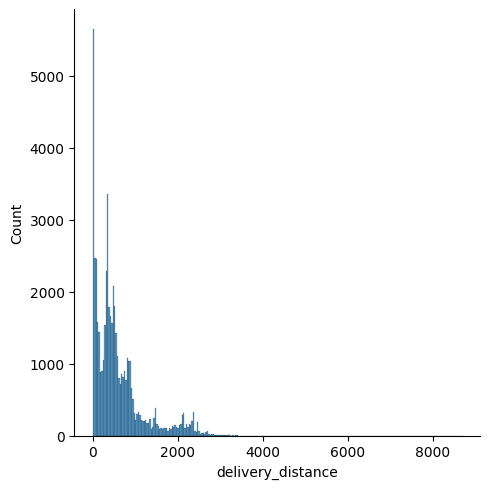

In [701]:
sns.displot(data=orders_df2, x='delivery_distance')

It's worth to mention that, regarding distribution of `delivery_distance` above, there are a lot of zero-valued distance, which is acceptable due to how the dataset averages multiple coordinates in a given area.

In some cases where delivery is within the same area, both `average_coordinate` will be the same, thus creating the illusion of zero distance.

Now we will create a new dataset for non-outliers in terms of `distance`.

In [702]:
# Calculate Z-score for delivery duration

delivery_distance_z_scores = stats.zscore(orders_df2['delivery_distance'])

orders_df2_nooutliers = pd.DataFrame()

# if Z-score is < 3, it's not an outlier
orders_df2_nooutliers['delivery_distance'] = [distance for distance, z_score in zip(orders_df2['delivery_distance'], delivery_distance_z_scores) if z_score < 3]
orders_df2_nooutliers['delivery_duration'] = [duration for duration, z_score in zip(orders_df2['delivery_duration'], delivery_distance_z_scores) if z_score < 3]
orders_df2_nooutliers['is_intercity'] = [is_intercity for is_intercity, z_score in zip(orders_df2['is_intercity'], delivery_distance_z_scores) if z_score < 3]

pct_data_removed = (len(orders_df2) - len(orders_df2_nooutliers)) / len(orders_df2)

print(f"{len(orders_df2) - len(orders_df2_nooutliers)} outlier rows removed, which consist of {pct_data_removed*100:.2f}% of the whole dataset.")


# clean up big array
del delivery_distance_z_scores
gc.collect()

1147 outlier rows removed, which consist of 2.18% of the whole dataset.


82

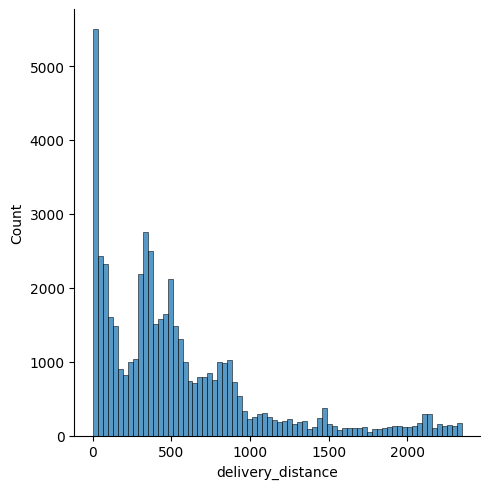

In [704]:
sns.displot(data=orders_df2_nooutliers, x='delivery_distance')

Step 2:

Now that we have two datasets (one with outlier removed), we can proceed to calculate correlation between delivery distance and duration; for both datasets.

In [705]:
print("Dataset with outliers intact")
orders_df2.corr(method='pearson', numeric_only=True)

Dataset with outliers intact


,purchase_month,delivery_duration,delivery_distance
purchase_month,1.000000,-0.302293,-0.029784
delivery_duration,-0.302293,1.000000,0.407373
delivery_distance,-0.029784,0.407373,1.000000


In [706]:
print("Dataset with outliers removed")
orders_df2_nooutliers.corr(method='pearson', numeric_only=True)

Dataset with outliers removed


,delivery_distance,delivery_duration
delivery_distance,1.000000,0.391625
delivery_duration,0.391625,1.000000


From here, we can conclude that:
- There are **medium positive correlation** between review score and delivery duration.
- That means, the further the customer is, the longer the delivery tend to be.
- Therefore, there is an opportunity for us to either
    - make delivery faster regardless of the distance, or
    - make sellers more accessible to the customers
- Additionally, the outlier data doesn't significantly affect the result of the analysis, so in the future we will include delivery_duration outliers.

---

### **3. Analyse whether we do intercity deliveries a lot -- do we need to expand our seller base?**

Step 1: Understand the trend

For this, we need to plot the trend of intercity deliveries vs intra-city.

<AxesSubplot: xlabel='delivery_distance', ylabel='is_intercity'>

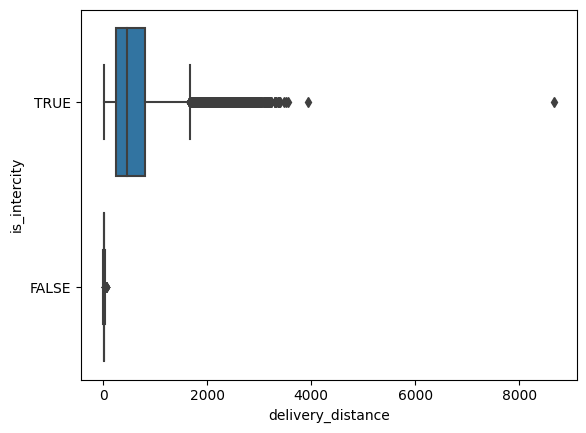

In [707]:
sns.boxplot(data=orders_df2, x='delivery_distance', y='is_intercity')

From here, we have established an understanding that intercity deliveries is further than intra-city (which also typically takes longer, based on the previous section).

Note: due to the geolocation data is around city-level, the distance is visualized closer to zero. This shouldn't be the case -- we can get a more accurate picture if we can increase the granularity of our geolocation data. However, we can confidently assume that intercity is further (and takes longer time) than intra-city deliveries.

Next, we will visualize how many orders are intercity vs intra-city. This will approximate the reach of our subsequent business/product strategy of improving deliveries.

<AxesSubplot: xlabel='purchase_month', ylabel='count'>

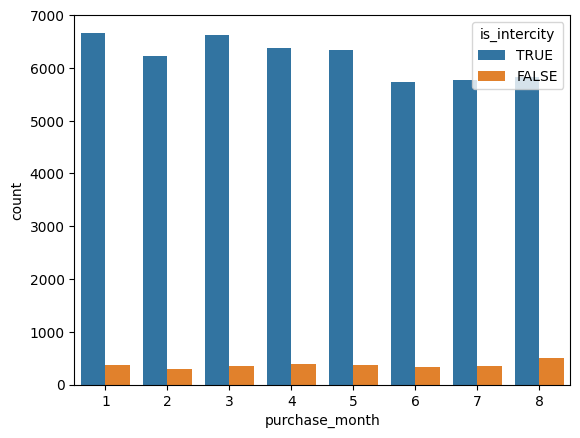

In [708]:
sns.countplot(data=orders_df2, x='purchase_month', hue='is_intercity')

From the data above, we can see that intercity orders are much more frequent than same-city orders, with similar fluctuating trends overall.

---

### **Overall conclusion**

Overall, We can conclude that **solving delivery experience is impactful** because:
- Customer satisfaction is partly driven by how long order delivery take
- Delivery distance is correlating positively to delivery duration
- Most of our orders are intercity, which tend to have a longer distance

Possible next steps for strategy can include:
- Acquire sellers in a more diverse set of cities, so that customers can find the closest ones
- Add some product functionalities so that the customers will know whether a delivery will take longer or not
- Add fulfillment centers in other cities so that deliveries can be faster (avoiding long duration due to intercity delivery process)

---

In [709]:
del orders_df1
del orders_df2
gc.collect()

NameError: name 'orders_df1' is not defined